In [2]:
!pip install tensorboardcolab
!pip show tensorflow
!pip install -q seaborn
!pip install fitter

from __future__ import absolute_import, division, print_function
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import metrics
import tensorflow as tf
from math import sqrt
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
import keras

def prepare_data():
  dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
  column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                  'Acceleration', 'Model Year', 'Origin'] 
  raw_dataset = pd.read_csv(dataset_path, names=column_names,
                            na_values = "?", comment='\t',
                            sep=" ", skipinitialspace=True)
  dataset = raw_dataset.copy()
  dataset.isna().sum()
  dataset = dataset.dropna()
  origin = dataset.pop('Origin')
  dataset['USA'] = (origin == 1)*1.0
  dataset['Europe'] = (origin == 2)*1.0
  dataset['Japan'] = (origin == 3)*1.0
  train_dataset = dataset.sample(frac=0.8,random_state=0)
  test_dataset = dataset.drop(train_dataset.index)
  train_stats = train_dataset.describe()
  train_stats.pop("MPG")
  train_stats = train_stats.transpose()
  train_labels = train_dataset.pop('MPG')
  print(train_labels[:2])
  test_labels = test_dataset.pop('MPG')
  def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
  normed_train_data = norm(train_dataset)
  normed_test_data = norm(test_dataset)
  
  return train_dataset, test_dataset, train_labels, test_labels,normed_train_data, normed_test_data 

Name: tensorflow
Version: 1.14.0rc1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: wrapt, astor, tensorflow-estimator, keras-applications, keras-preprocessing, absl-py, six, numpy, termcolor, google-pasta, tensorboard, grpcio, wheel, gast, protobuf
Required-by: stable-baselines, magenta, fancyimpute


#### This is a reimplementation of the model in `es.ipynb` with Tensorflow low level API to access the loss of each sample. 

Keras does not provide API to run `tf.Session()`, therefore, it is impossible to evaluate the inidividual `y_pred` tensor of each sample during training. The closest solution under keras framework is `callbacks.on_batch_begin` which is not desable for this project and badly limited debugging capacity. Below is a list of possible solutions I tried but turned out not working:

* Access values of y_pred/y_true in each batch by defining custom_loss
Failed, because I can’t find out how to print or eval tensor y_pred/p_true

* Pass losses to custom_loss by defining callbacks
Failed because callbacks is called in model.fit() leaving it uninitialized when being called by custom_loss which is given in model.compile()

* Predict a batch of models by processing same models paralelly
Failed, because models have to be connected together at some point to be processed together which will introduce artificial weights

#### What I will do next:

* Finally, this research is concentrating on traffic image data, it is not feasable to reimplement those popular models in such low level API, therefore I will try `Eager Execution` and `Estimator` next step.


In [0]:
def plot_bar(errors, num):
    plt.hist(errors, bins = 20)
    plt.xlabel("Prediction Error [MPG]")
    title = "epoch:" + str(num)
    plt.title(title)
    _ = plt.ylabel("Count")
    plt.show()
    plt.savefig(title)

146    28.0
282    22.3
Name: MPG, dtype: float64
--------------------


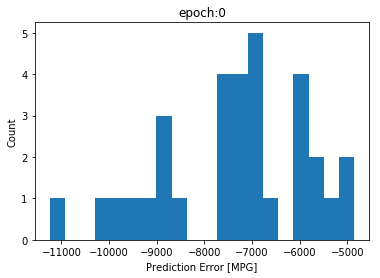

--------------------
Epoch: 0 , Cost = 391039216.0
--------------------


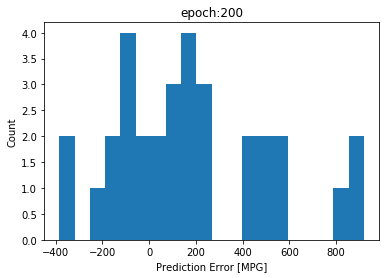

--------------------
Epoch: 200 , Cost = 109348.45746527777
--------------------


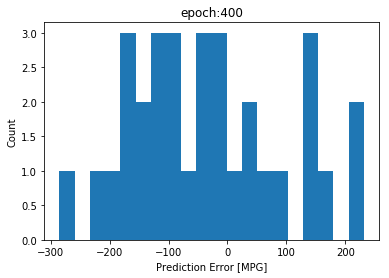

--------------------
Epoch: 400 , Cost = 15577.412000868055
81.3298736003183


<Figure size 432x288 with 0 Axes>

In [6]:
train_dataset, test_dataset, train_labels, test_labels, normed_train_data, normed_test_data = prepare_data()
train_dataset = train_dataset.values
train_labels = train_labels.values
test_dataset = test_dataset.values
test_labels = test_labels.values
train_labels = np.reshape(train_labels, [train_labels.shape[0],1])
test_labels = np.reshape(test_labels, [test_labels.shape[0],1])

# Parameters
learning_rate = 0.001
batch_size = 32
display_step = 1
epochs = 500

# Network Parameters
n_hidden_1 = 64 # 1st layer number of neurons
n_hidden_2 = 64 # 2nd layer number of neurons
n_input = 9 # dataset has 9 features
n_output = 1 # regress to single value MPG

# tf Graph input
x = tf.placeholder("float", [None, n_input], name = 'placeholder_x')
y = tf.placeholder("float", [None, 1], name = 'placeholder_y')

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_output]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_output]))
}

# Create model
def multilayer_perceptron(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer # no activation function for the output layer

# Construct model
y_pred = multilayer_perceptron(x)


# define a loss function
mse = tf.losses.mean_squared_error(labels = y, predictions = y_pred)
                       
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mse)
# Initializing the variables
init = tf.global_variables_initializer()


with tf.Session() as sess:
		# initialize variables
		sess.run(init)
		# find the total number of batches
		total_batch = int(train_dataset.shape[0] / batch_size)
		# now run for each epoch
		for epoch in range(epochs):
			avg_cost = 0
			for i in range(total_batch):
				start = i * batch_size
				end = min(i*batch_size + batch_size, train_dataset.shape[0])
				x_batch, y_batch = train_dataset[start:end, :], train_labels[start:end, :]
				_, c = sess.run([optimizer, mse], feed_dict = {x: x_batch, y: y_batch})
				avg_cost += c / total_batch
        
			if epoch % 200 ==0:
				pred = sess.run(y_pred, feed_dict = {x: x_batch})
				print("--------------------")
				#print('Epoch:', epoch, pred)
				errors = y_batch - pred
				plot_bar(errors, epoch)
				print("--------------------")
				print('Epoch:', epoch, ', Cost =', avg_cost)

		print(sqrt(sess.run(mse, feed_dict = {x: test_dataset, y: test_labels})))
		# keep the prediction for later
		pred = sess.run(y_pred, feed_dict = {x:test_dataset})

The prediction is clealy improved with the naive `mse` loss. I ignored the possible good practice of  `early_stopping` here since I probably will migrate everything again to `Eager Execution` later. 

Now we reproduced the model, we will go ahead define the loss function.

Note that KL divergence cannot be used to measure the distance between a pdf and a pmd, so we need to infer the error distribution from the data first. 

There are three ways to do this:


*   fitting to the best know distribution
*   curve fitting
*  MSE of sample histogram and target distribution

####  fitting to the best know distribution

We hope the first one will work since it will give a better explanation and a possible analytical tractable statistics. Let's try out the first one first. 

We assume the errorrs are independent and identically distributed which is not necessarily true. We are supposed to test the homoscedasticity of the errors, but we will skip it for now. 

Fitting data to a distribution is a very costly computationally, especially given how many batchs and epochs a task usually takes. But we are not very concerned with training time in this project. Here, we used a library called `fitter`, it provides 80ish distributions. Also, the following two aspects can be improved to speed up this distance calculation:

* implement on GPU. This is paralellizable because we can try out all possible distribution simultanously. 
* limit the potential distributions. All 80ish distributions are tested out here. 

Unfortunately, `tfp`(`tensorflow_probability`, a library has to be installed seaprately from `tf`)  does not support this distribution, so we will try other candidate distributions.  The distributions [supported](https://www.tensorflow.org/api_docs/python/tf/distributions) by `tfp` are: 

* Bernoulli distribution.

* Beta distribution.

* Categorical distribution.

* Dirichlet distribution.

* Dirichlet-Multinomial compound distribution.

* Exponential distribution.

* Gamma distribution.

* Laplace distribution.

* Multinomial distribution.

* Normal distribution.

* Student's t-distribution.

* Uniform distribution



`nct` ([Noncentral t-distribution](https://en.wikipedia.org/wiki/Noncentral_t-distribution)) is a geralization of Student's t-distribution. 



             sumsquare_error
johnsonsu       5.689559e-07
nct             5.726557e-07
tukeylambda     5.729001e-07
t               5.761149e-07
cauchy          5.852733e-07


'\nFitted alpha distribution with error=2.5896434941593034e-06)\nFitted anglit distribution with error=1.8490308166175003e-06)\nFitted arcsine distribution with error=2.3650134274947353e-06)\nFitted argus distribution with error=1.6705936419216382e-06)\nFitted beta distribution with error=9.775074086877225e-07)\nFitted betaprime distribution with error=3.932034388814638e-06)\nFitted bradford distribution with error=2.0275224201997635e-06)\nFitted burr distribution with error=3.1779368224083834e-06)\nFitted burr12 distribution with error=3.3938193992295923e-06)\nFitted cauchy distribution with error=5.852733098970629e-07)\nFitted chi distribution with error=2.5767699020623483e-06)\nFitted chi2 distribution with error=2.536480829234903e-06)\nFitted cosine distribution with error=1.6933543903261163e-06)\nFitted crystalball distribution with error=9.979767408215378e-07)\nFitted dgamma distribution with error=6.106380511441577e-07)\nFitted dweibull distribution with error=5.930971161049491e

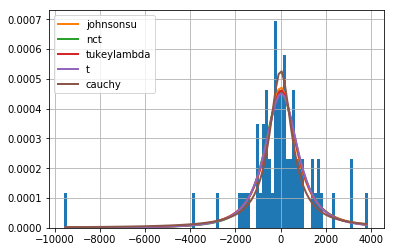

In [0]:
from fitter import Fitter
f = Fitter(errors)
#f = Fitter(errors, distributions=['gamma', 'rayleigh', 'uniform'])
f.fit()
print(f.summary())

"""
Fitted alpha distribution with error=2.5896434941593034e-06)
Fitted anglit distribution with error=1.8490308166175003e-06)
Fitted arcsine distribution with error=2.3650134274947353e-06)
Fitted argus distribution with error=1.6705936419216382e-06)
Fitted beta distribution with error=9.775074086877225e-07)
Fitted betaprime distribution with error=3.932034388814638e-06)
Fitted bradford distribution with error=2.0275224201997635e-06)
Fitted burr distribution with error=3.1779368224083834e-06)
Fitted burr12 distribution with error=3.3938193992295923e-06)
Fitted cauchy distribution with error=5.852733098970629e-07)
Fitted chi distribution with error=2.5767699020623483e-06)
Fitted chi2 distribution with error=2.536480829234903e-06)
Fitted cosine distribution with error=1.6933543903261163e-06)
Fitted crystalball distribution with error=9.979767408215378e-07)
Fitted dgamma distribution with error=6.106380511441577e-07)
Fitted dweibull distribution with error=5.930971161049491e-07)
Fitted erlang distribution with error=2.5767699020623483e-06)
Fitted expon distribution with error=2.3593689413192375e-06)
Fitted gengamma distribution with error=3.798294053829713e-06)
Fitted genhalflogistic distribution with error=1.8665745961974646e-06)
Fitted genlogistic distribution with error=7.201253730508548e-07)
Fitted gennorm distribution with error=5.896728594637419e-07)
Fitted genpareto distribution with error=3.4260105798267425e-06)
Fitted gilbrat distribution with error=2.245159964161285e-06)
Fitted gompertz distribution with error=2.5767699020623483e-06)
Fitted gumbel_l distribution with error=1.0537582416010148e-06)
Fitted gumbel_r distribution with error=1.5629413141089086e-06)
Fitted halfcauchy distribution with error=2.3050050431287403e-06)
Fitted halfgennorm distribution with error=2.863196358138618e-06)
Fitted halflogistic distribution with error=2.255705033437357e-06)
Fitted halfnorm distribution with error=2.237239554714266e-06)
Fitted hypsecant distribution with error=6.550145015133801e-07)
Fitted invgamma distribution with error=1.2033554671245813e-06)
Fitted invgauss distribution with error=2.3575385356709234e-06)
Fitted invweibull distribution with error=2.920052067132609e-06)
Fitted johnsonsb distribution with error=9.449127678636675e-07)
Fitted johnsonsu distribution with error=5.689559180234113e-07)
Fitted kappa3 distribution with error=2.9795608572648376e-06)
Fitted kappa4 distribution with error=2.000734392053004e-06)
Fitted ksone distribution with error=2.027058989622382e-06)
Fitted kstwobign distribution with error=2.5767699020623483e-06)
Fitted laplace distribution with error=5.896459965945434e-07)
Fitted levy distribution with error=2.3575236827892297e-06)
Fitted levy_l distribution with error=2.0459599386881123e-06)
SKIPPED levy_stable distribution (taking more than 30 seconds)
Fitted loggamma distribution with error=9.302238786446436e-07)
Fitted logistic distribution with error=7.125921794153209e-07)
Fitted loglaplace distribution with error=2.761080438959571e-06)
Fitted lognorm distribution with error=2.8973587150062048e-06)
Fitted lomax distribution with error=3.6380518541770345e-06)
Fitted maxwell distribution with error=2.5767699020623483e-06)
Fitted mielke distribution with error=1.7766248979920645e-06)
Fitted moyal distribution with error=1.0679582260725692e-06)
Fitted nakagami distribution with error=2.5767699020623483e-06)
Fitted ncf distribution with error=3.1779843779208683e-06)
Fitted nct distribution with error=5.726556988406777e-07)
Fitted ncx2 distribution with error=2.5744125170411347e-06)
Fitted norm distribution with error=9.97976730889163e-07)
Fitted norminvgauss distribution with error=2.3014483124511963e-06)
Fitted pareto distribution with error=3.637767279721138e-06)
Fitted pearson3 distribution with error=9.542329537371274e-07)
Fitted powerlaw distribution with error=1.8186637279548118e-06)
Fitted powerlognorm distribution with error=3.011884486309778e-06)
Fitted powernorm distribution with error=9.387474393488969e-07)
Fitted rayleigh distribution with error=1.9500437802475487e-06)
Fitted rdist distribution with error=3.5906412544799025e-06)
Fitted recipinvgauss distribution with error=9.681082785490822e-07)
Fitted reciprocal distribution with error=2.5767699020623483e-06)
Fitted rice distribution with error=2.5767699020623483e-06)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
Fitted semicircular distribution with error=1.957063462230919e-06)
Fitted skewnorm distribution with error=9.97976723164225e-07)
Fitted t distribution with error=5.761148986749734e-07)
Fitted trapz distribution with error=1.8035907945119612e-06)
Fitted triang distribution with error=1.5165715831406176e-06)
Fitted truncexpon distribution with error=2.2015867586006195e-06)
Fitted truncnorm distribution with error=2.5767699020623483e-06)
Fitted tukeylambda distribution with error=5.72900098009525e-07)
Fitted uniform distribution with error=2.027058989622382e-06)
Fitted vonmises distribution with error=1.1001518943824533e+61)
Fitted vonmises_line distribution with error=8.158148122394506e-07)
Fitted wald distribution with error=2.2130802719697525e-06)
Fitted weibull_max distribution with error=2.6491046157408397e-06)
Fitted weibull_min distribution with error=2.7089484496990918e-06)

"""

In [12]:
f.fitted_param['t']

(9078.348943786528, -33.94186420648761, 126.75643923281449)

['gumbel_r' 'alpha' 'skewnorm' 'mielke' 'genlogistic']


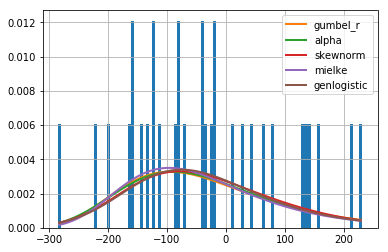

In [17]:
print(f.summary().index.values)

In this specific example, the best fitted distribution is Johnson's SU-distribution with the listed 4 parameters. 

Now, we need to reconstruct this distribution via the language of tensorflow. 

In [0]:
print(f.get_best())

{'johnsonsu': (-0.02971723716650601,
  0.890681179295507,
  0.5038289220040495,
  753.7279967421016)}

The bottleneck of this distribution fitting process is the `f.fit()` in `fitter` package, more specifically, is the number of bins when the package generated `y` of histogram from the 1D data. Their souce code can be found [here](https://pythonhosted.org/fitter/_modules/fitter/fitter.html#Fitter), you can see the calculation is senstive to number of bins of `numpy.histogram` which defaults to 100. The evaluation of fitting distribution is given as:

![alt text](http://i66.tinypic.com/2555i15.png)

This calculation itself may be used as the measurement of the distance between the distribution of the discrete samples and the target continuous ditribution.

#### curve fitting

Now, let's consider curve fitting. Compared to distribution fitting, curve fittiing for probability has 3 problems:


1.   Curve fitting requres data has 2 dimensions, we can achieve this by further discrete and accumulate points to have `count` as y value. Let's say we cluster 1D data into 20 equal distance groups between the minimum and maximum values. But note this added subjectivity and lost some information.

2.   Traditional way of curve fitting is to define the degree of your polynomial curve function, this hyper-parameter selection needs we visualize the data which is infeasible in this project. We can either use a very general form polynomial (`A * np.exp(-x/beta) + B * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2))`) or the simplist neuranet work to approximate the error distribution curve. This has same problem as above. We can also use bidirectional moving average, it has hyper-parameter of lagging steps too.

3. As a pdf. the curve has to be integrated to 1. This means the curve has to be normalized for the area along the support and the boundary has to be closed or asymptotically to be zero.

4. Possibly there may be some numerical instability caused by unique density function. An example is the need to customize automatic differentiation in tensorflow: [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape)

Give these two barriers, I will skip this option and assum the errors follows a known distribution. 

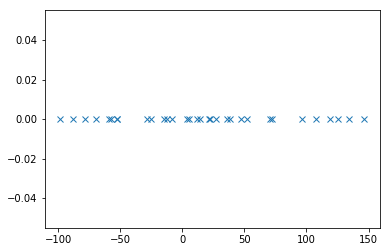

In [0]:
plt.plot(errors, np.zeros_like(errors), 'x')
plt.show()

(array([3., 5., 1., 4., 6., 4., 3., 1., 2., 3.]),
 array([-98.58079529, -74.06419449, -49.54759369, -25.03099289,
         -0.51439209,  24.00220871,  48.51880951,  73.03541031,
         97.55201111, 122.06861191, 146.58521271]),
 <a list of 10 Patch objects>)

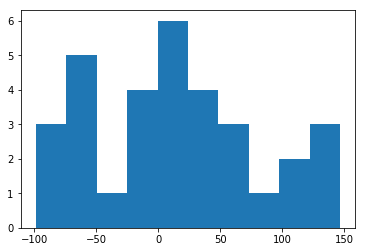

In [0]:
plt.hist(errors)

#### MSE of sample histogram and target distribution

This method is sensitive to the choice of bins number when getting histogram of sample, but we will ignore it for now.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # This is added back by InteractiveShellApp.init_path()


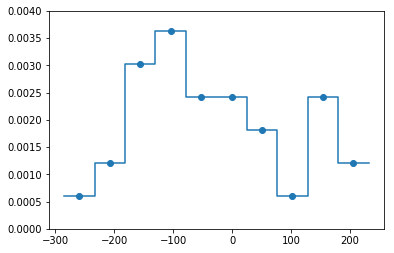

mse = 0.005684192209950782


In [71]:
import scipy 

def get_distance_between_samples_and_distribution(errors, if_plot = 1, n_bins = 10):
  def get_middle(x):
    xMid = np.zeros(x.shape[0]//2)
    for i in range(xMid.shape[0]):
      xMid[i] = 0.5*(x[2*i]+x[2*i+1])
    return xMid
  
  # get_pmf_from_1d
  bins, edges = np.histogram(errors, n_bins, normed=1)
  left,right = edges[:-1],edges[1:]
  X = np.array([left,right]).T.flatten()
  Y = np.array([bins,bins]).T.flatten()
  X_middle = get_middle(X)
  Y_middle = get_middle(Y)

  if if_plot == 1:
    plt.plot(X,Y)
    plt.scatter(X_middle,Y_middle)
    axes = plt.gca()
    y_max = np.amax(Y_middle)*1.1
    axes.set_ylim([0,y_max])
    plt.show()

  distance = []
  for i in range(X_middle.shape[0]):
    dis = np.abs(scipy.stats.norm.pdf(X_middle[i])- Y_middle[i])
    distance.append(dis)
  distance2 = np.power(distance, 2)
  
  return sum(distance2)/len(distance2)

print("mse =", get_distance_between_samples_and_distribution(errors))